# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install nltk
!pip install -U spacy
!pip install --user -U tensorflow
!pip install transformers
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [2]:
from pandas_profiling import ProfileReport

import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import nltk

## Load Data

In [5]:
#import data
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()
df_reviews_dummies = pd.get_dummies(df_reviews,columns=['ds_part'],drop_first=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### Conclusions

This dataset contains 17 variables with 47,331 observations. In the models, we are going to only use `review` for sentiment analysis, but the other variables can help us understand the balance of the train and test groups.  

## EDA

### Profile Report

In [7]:
profile = ProfileReport(df_reviews_dummies)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Conclusions

There are a few major takeaways from the Profile Report above. 

1. Movie Reviews seemed to have become popular around the 1970's. 
2. I am unsure what `end_year` was supposed to represent, but almost all the values are /N, which means the variable is not very helpful.
3. Nearly all the movie's in the dataset are non-adult movies.
4. There were two rating variables: `average_rating` and `rating`. `average_rating` has a fairly normal distribution, but `rating`, has a high number of extreme values and has zero values of 5 or 6. My best guess as to the reason for this is that the data engineer wanted to isolate reviews that had a clear sentiment.
5. The number of positive and negative reviews is nearly identical, which means we do not have an issue of class imbalance.
6. The train/test variable is not highly correlated with any of the other variables. This eases the concern of differences in the training and testing sets.

### Distribution of Number of Reviews per Movie 

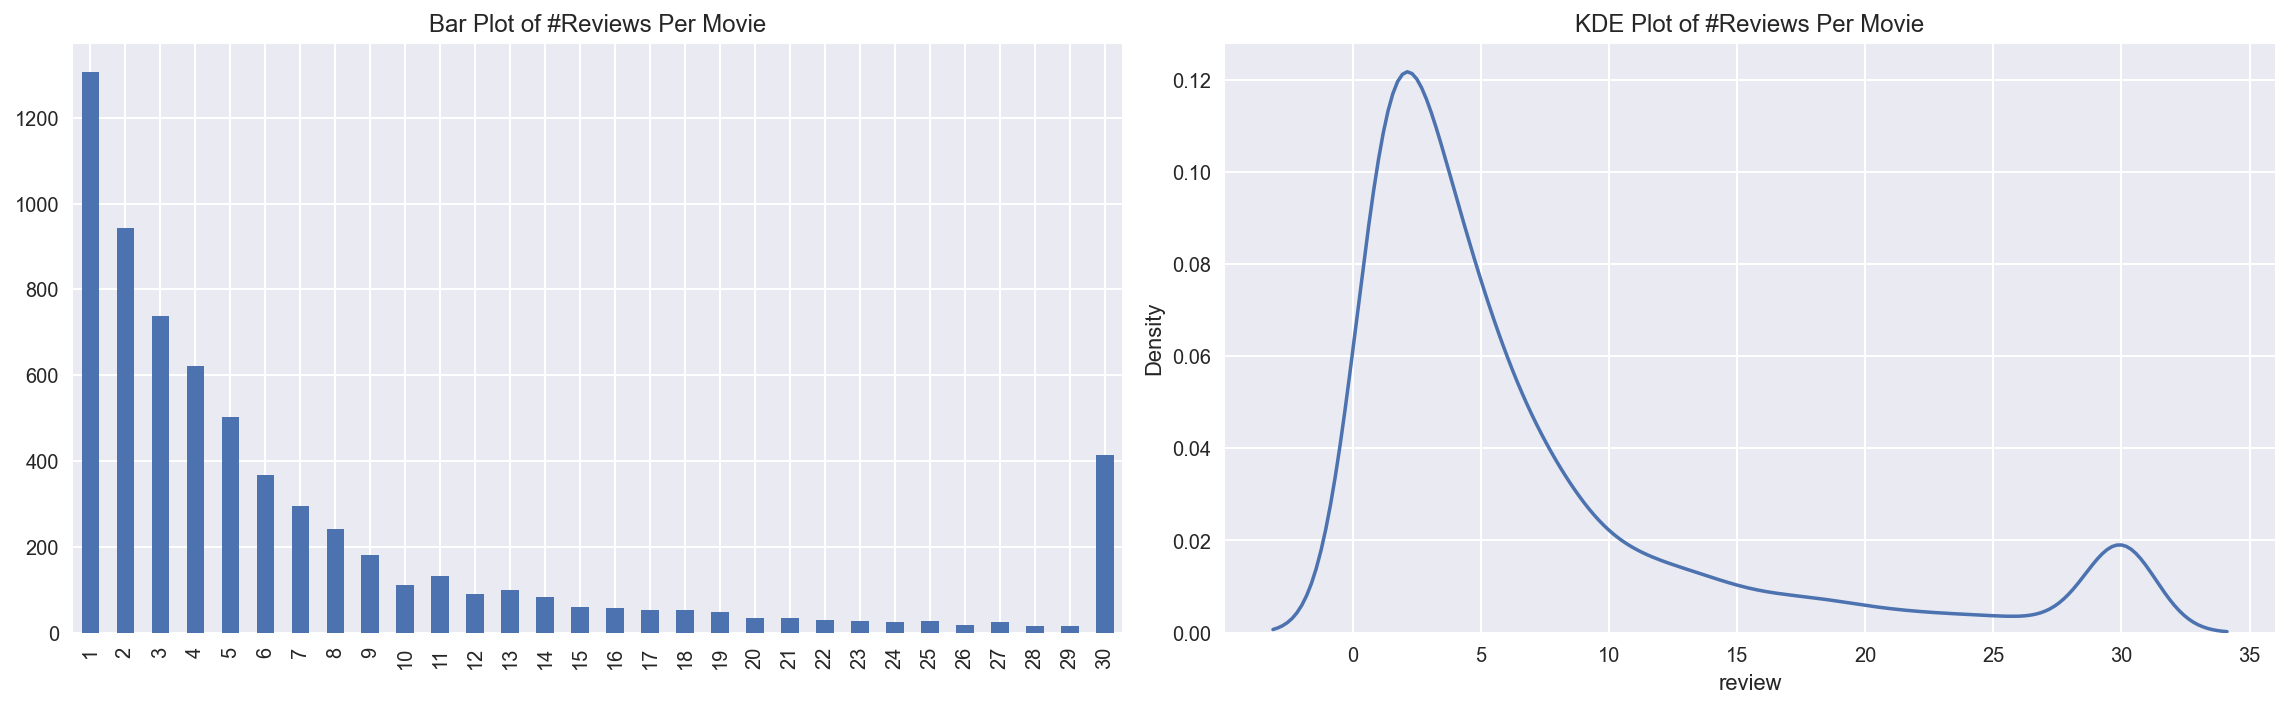

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

#### Conclusions

In the above graph, it seems as though most movies have a fairly low number of reviews. Also, due to the random spike and maximum of 30 reviews, I would assume the data engineer did not include more than 30 reviews for any movie. 

### Distribution of Negative and Positive Reviews

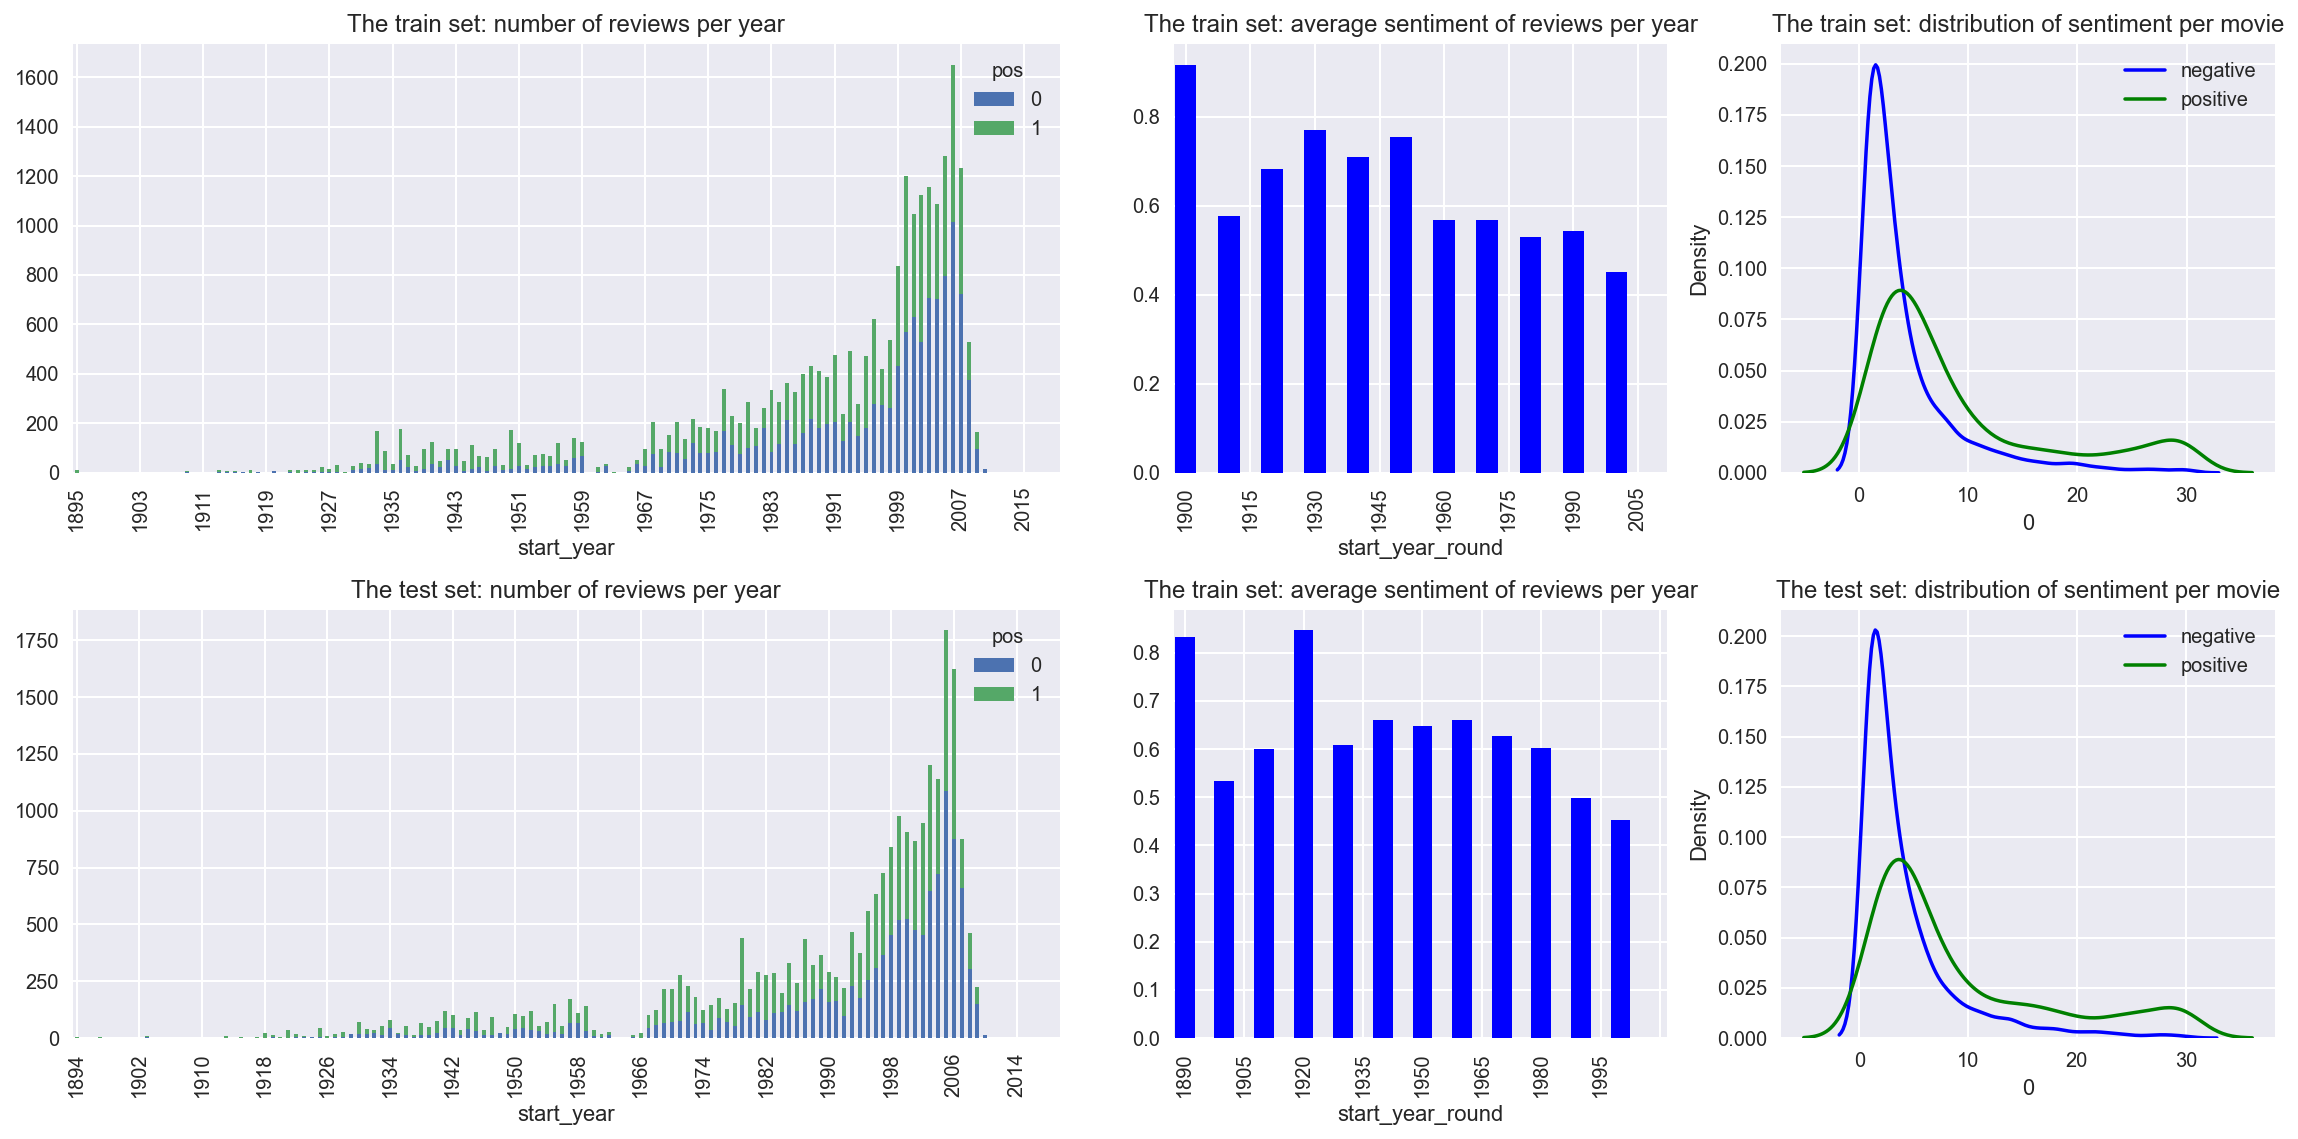

In [94]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1,1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews per year')
x_ticks = np.arange(1894, 2010, 50)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

ax = axs[0][1]

df_reviews['start_year_round'] = round(df_reviews['start_year']/10)*10
dft = df_reviews.query('ds_part == "train"').groupby(['start_year_round'])['pos'].mean()
dft = dft.reindex(index=np.arange(int(dft.index.min()), int(dft.index.max()))).fillna(0)
dft.plot(kind='bar', ax=ax,color='blue',width=5.0)
ax.set_title('The train set: average sentiment of reviews per year')
x_ticks = np.arange(1894, 2010, 50)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax = axs[0][2]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of sentiment per movie')


ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews per year')

ax.xaxis.set_major_locator(plt.MaxNLocator(20))

ax = axs[1][1]

df_reviews['start_year_round'] = round(df_reviews['start_year']/10)*10
dft = df_reviews.query('ds_part == "test"').groupby(['start_year_round'])['pos'].mean()
dft = dft.reindex(index=np.arange(int(dft.index.min()), int(dft.index.max()))).fillna(0)
dft.plot(kind='bar', ax=ax,color='blue',width=5.0)
ax.set_title('The train set: average sentiment of reviews per year')
x_ticks = np.arange(1894, 2010, 50)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax = axs[1][2]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of sentiment per movie')

fig.tight_layout()

#### Conclusions

The far left graphs show an exponential increase in the number of movie reviews per year. Additionally, when we look at the middle graphs, we can see that the percent of reviews that are positive, per year, seem to be slowly decreasing. Lastly, looking at the far right graphs, we can see that movies with low numbers of reviews are more likely to have a higher proportion of negative reviews. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [10]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [11]:
import re 

def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.lower()
    text = text.split()
    text = ' '.join(text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

### Conclusions

To normalize the text, I started out by removing all non-letters and apostrophes. Then, I removed excess spaces and made the text lowercase. This should allow for better performance when vectorizing the text.  

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [13]:
from sklearn.dummy import DummyClassifier

In [14]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

In [15]:
model_0 = DummyClassifier()
model_0.fit(train_features_0, train_target)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


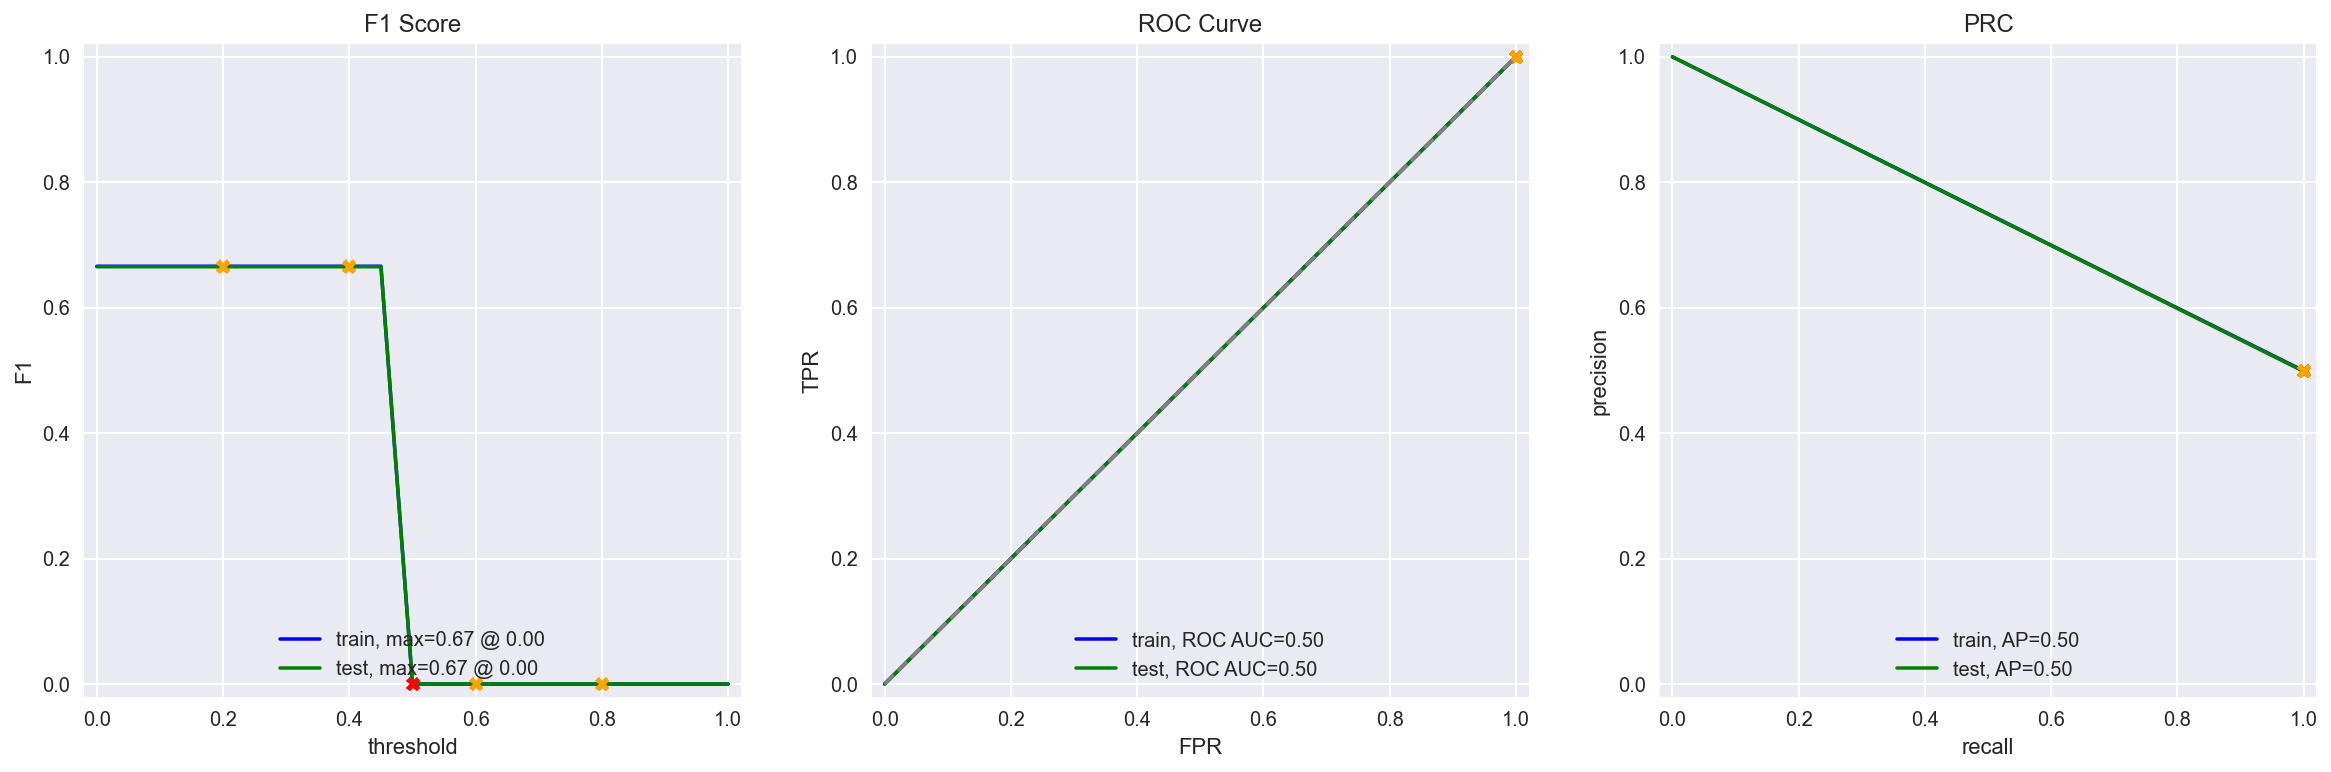

In [16]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

### Model 1 - NLTK, TF-IDF and LR

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [54]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

features_fit_1 = count_tf_idf.fit(train_features_0)
train_features_1 = features_fit_1.transform(train_features_0)
test_features_1 = features_fit_1.transform(test_features_0)

In [57]:
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


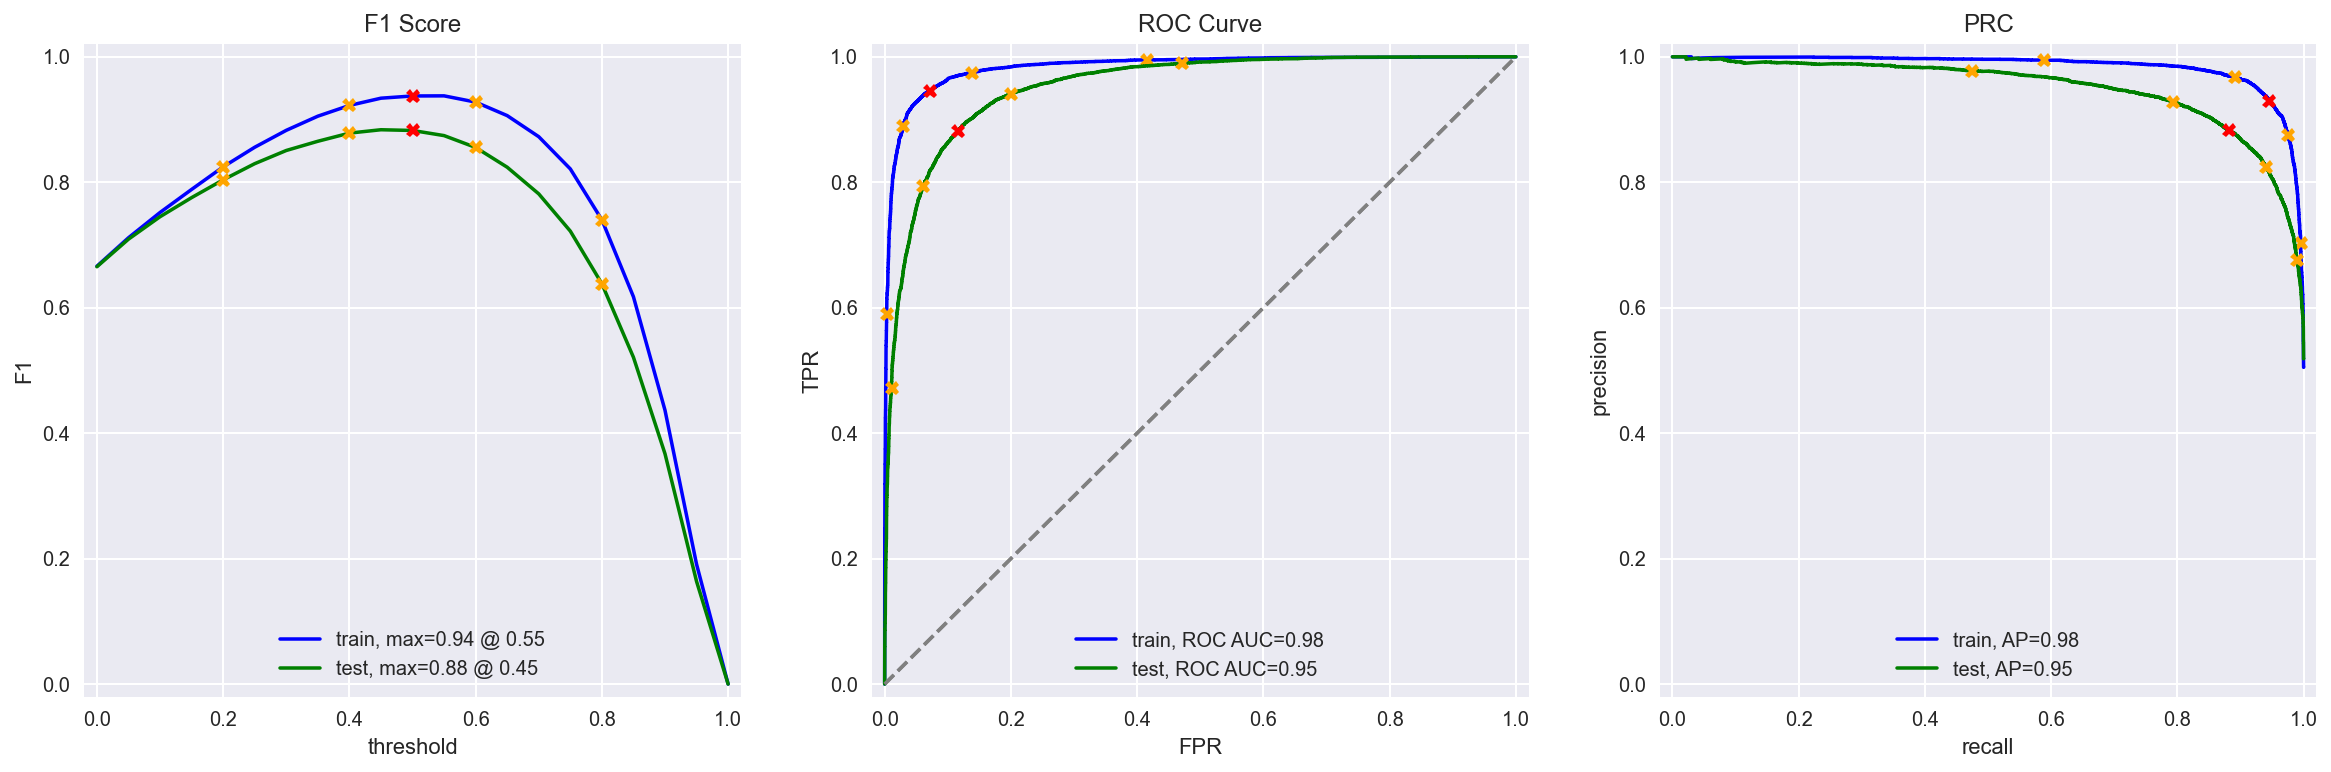

In [20]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [21]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [23]:
df_reviews_train['review_norm_lemma'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_lemma'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [24]:
features_fit_2 = count_tf_idf.fit(df_reviews_train['review_norm_lemma'])
train_features_2 = features_fit_2.transform(df_reviews_train['review_norm_lemma'])
test_features_2 = features_fit_2.transform(df_reviews_test['review_norm_lemma'])
model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


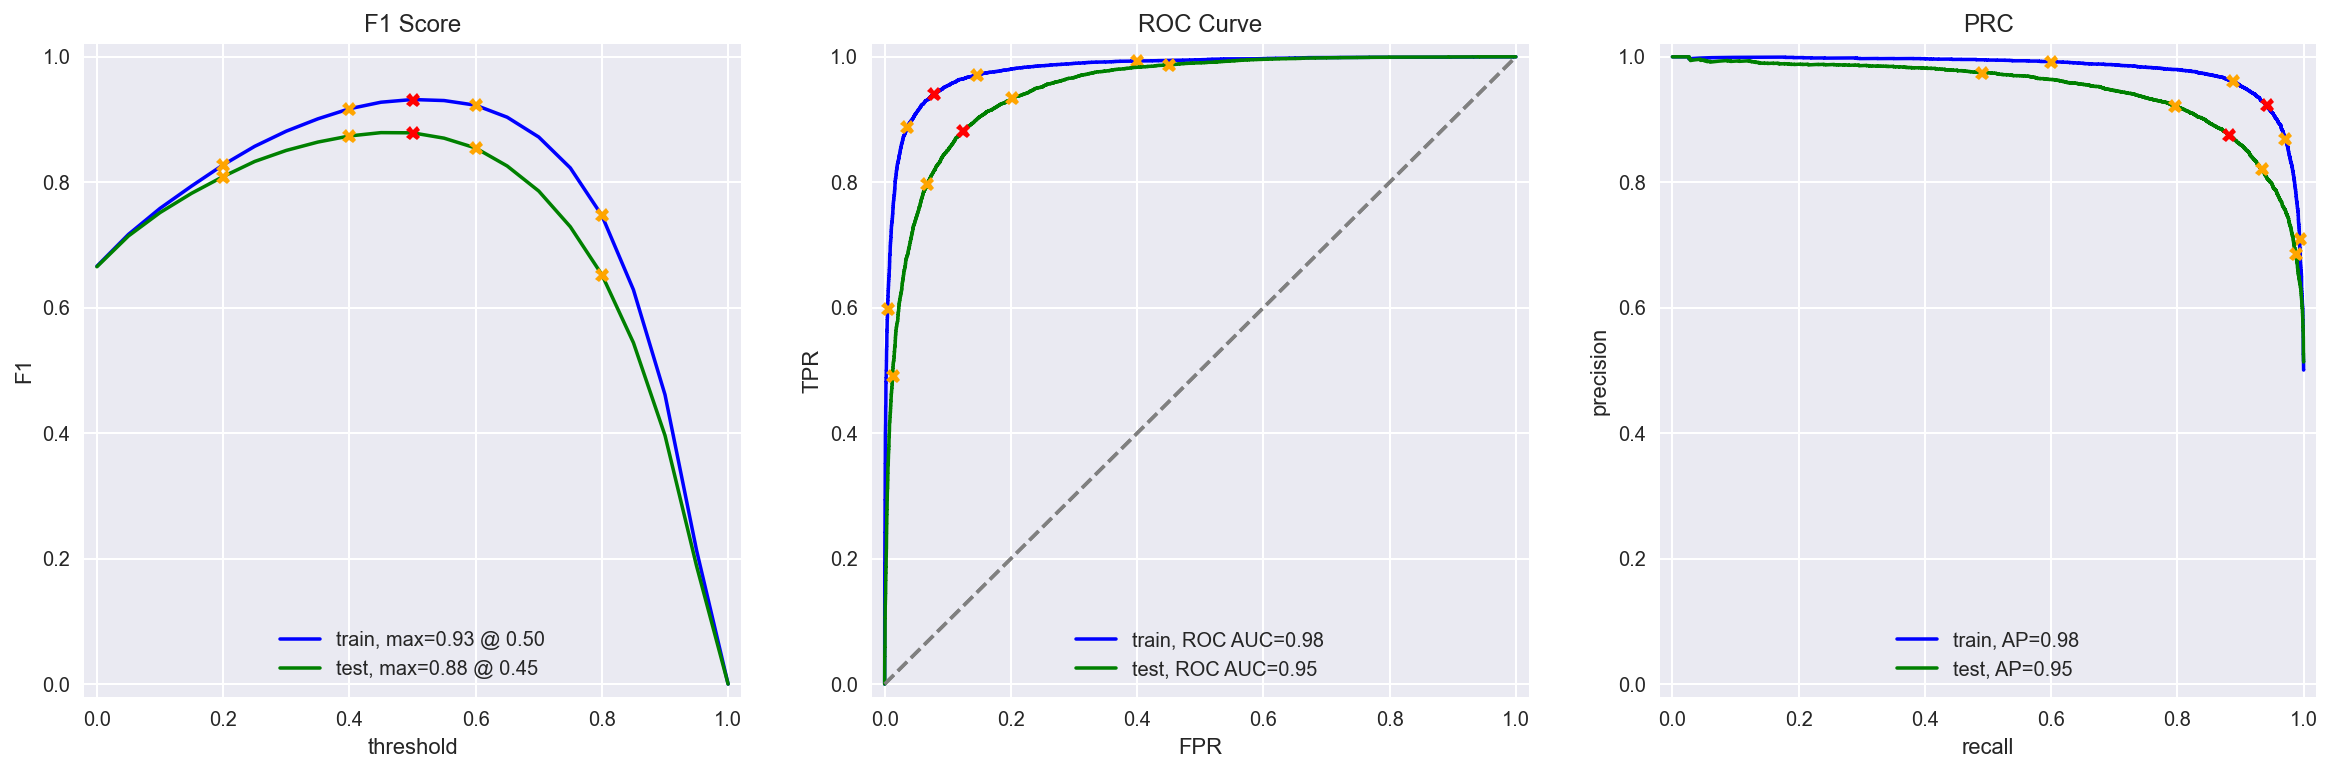

In [25]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [26]:
from lightgbm import LGBMClassifier

In [27]:
model_3 = LGBMClassifier()
model_3.fit(train_features_2,train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


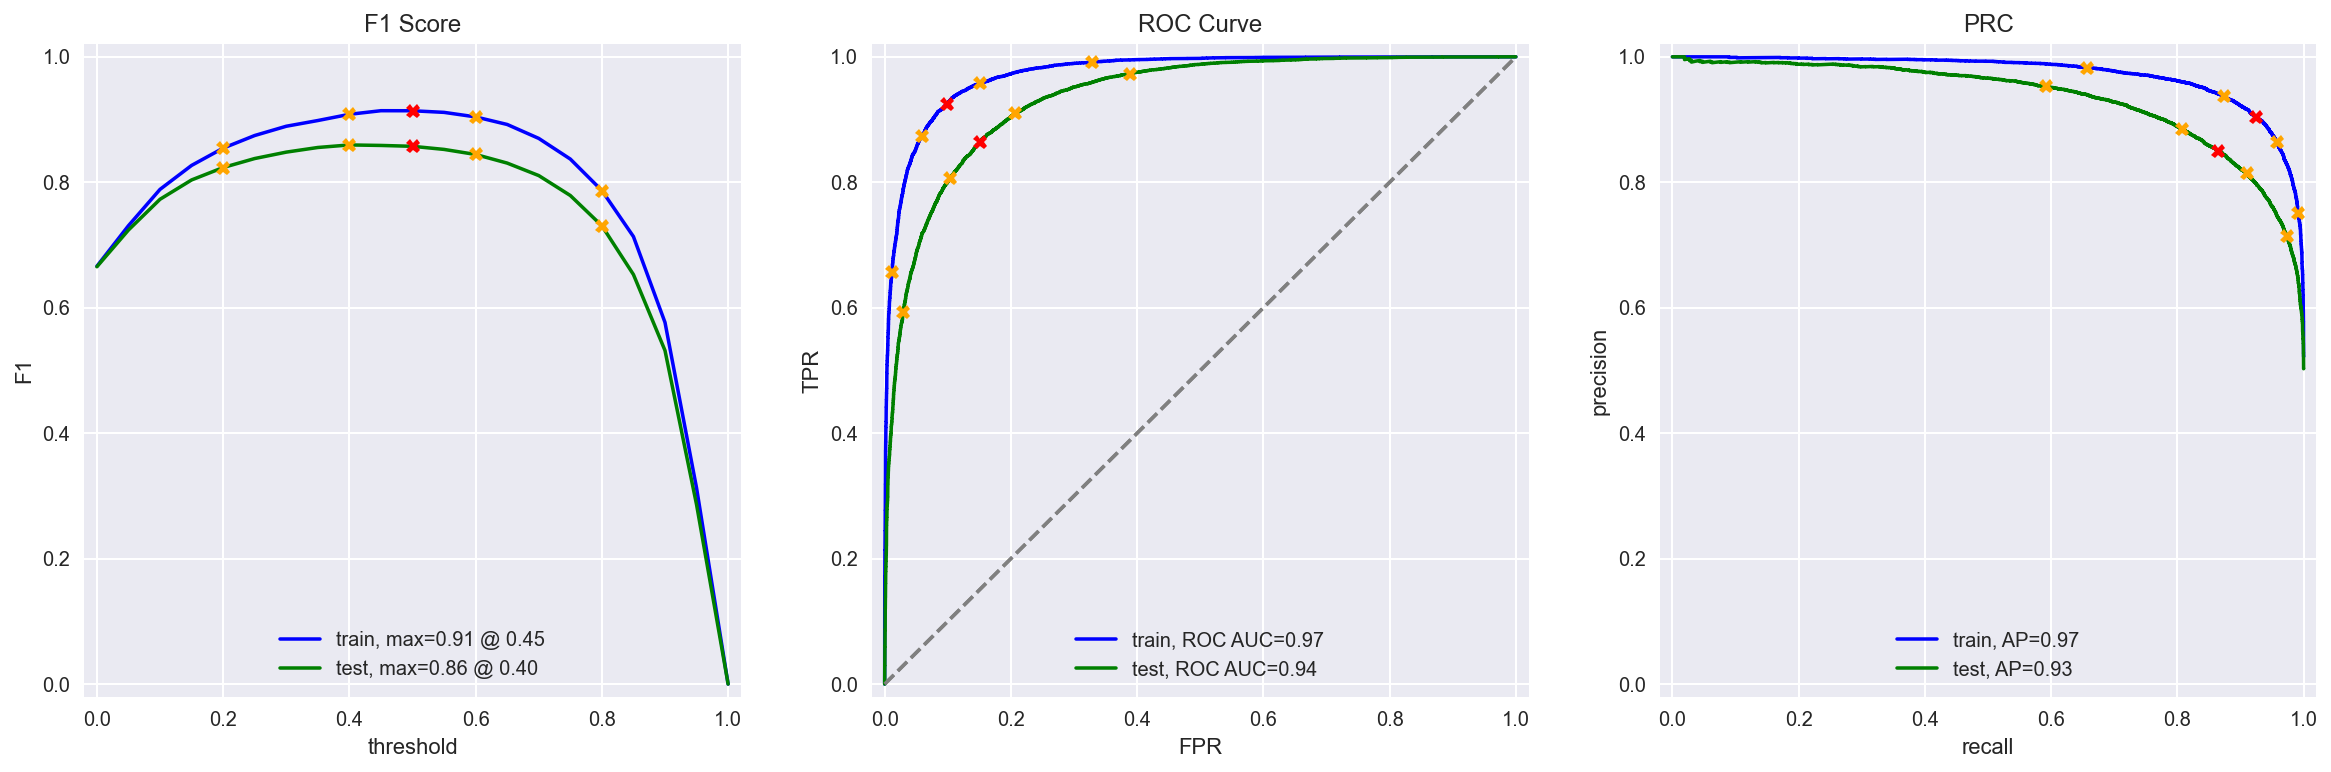

In [28]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

<div class="alert alert-block alert-info">
<b>Improve: </b> You could acheve better score if you've tuned parameters.
</div>

###  Model 4/5 - BERT

In [29]:
import torch
import transformers

In [30]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [32]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_4 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

C:\Users\bnoah\AppData\Local\Temp/ipykernel_21904/4093772636.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [33]:
test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/236 [00:00<?, ?it/s]

In [34]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)

# and load...
with np.load('features_4.npz') as data:
    train_features_4 = data['train_features_4']
    test_features_4 = data['test_features_4']

          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


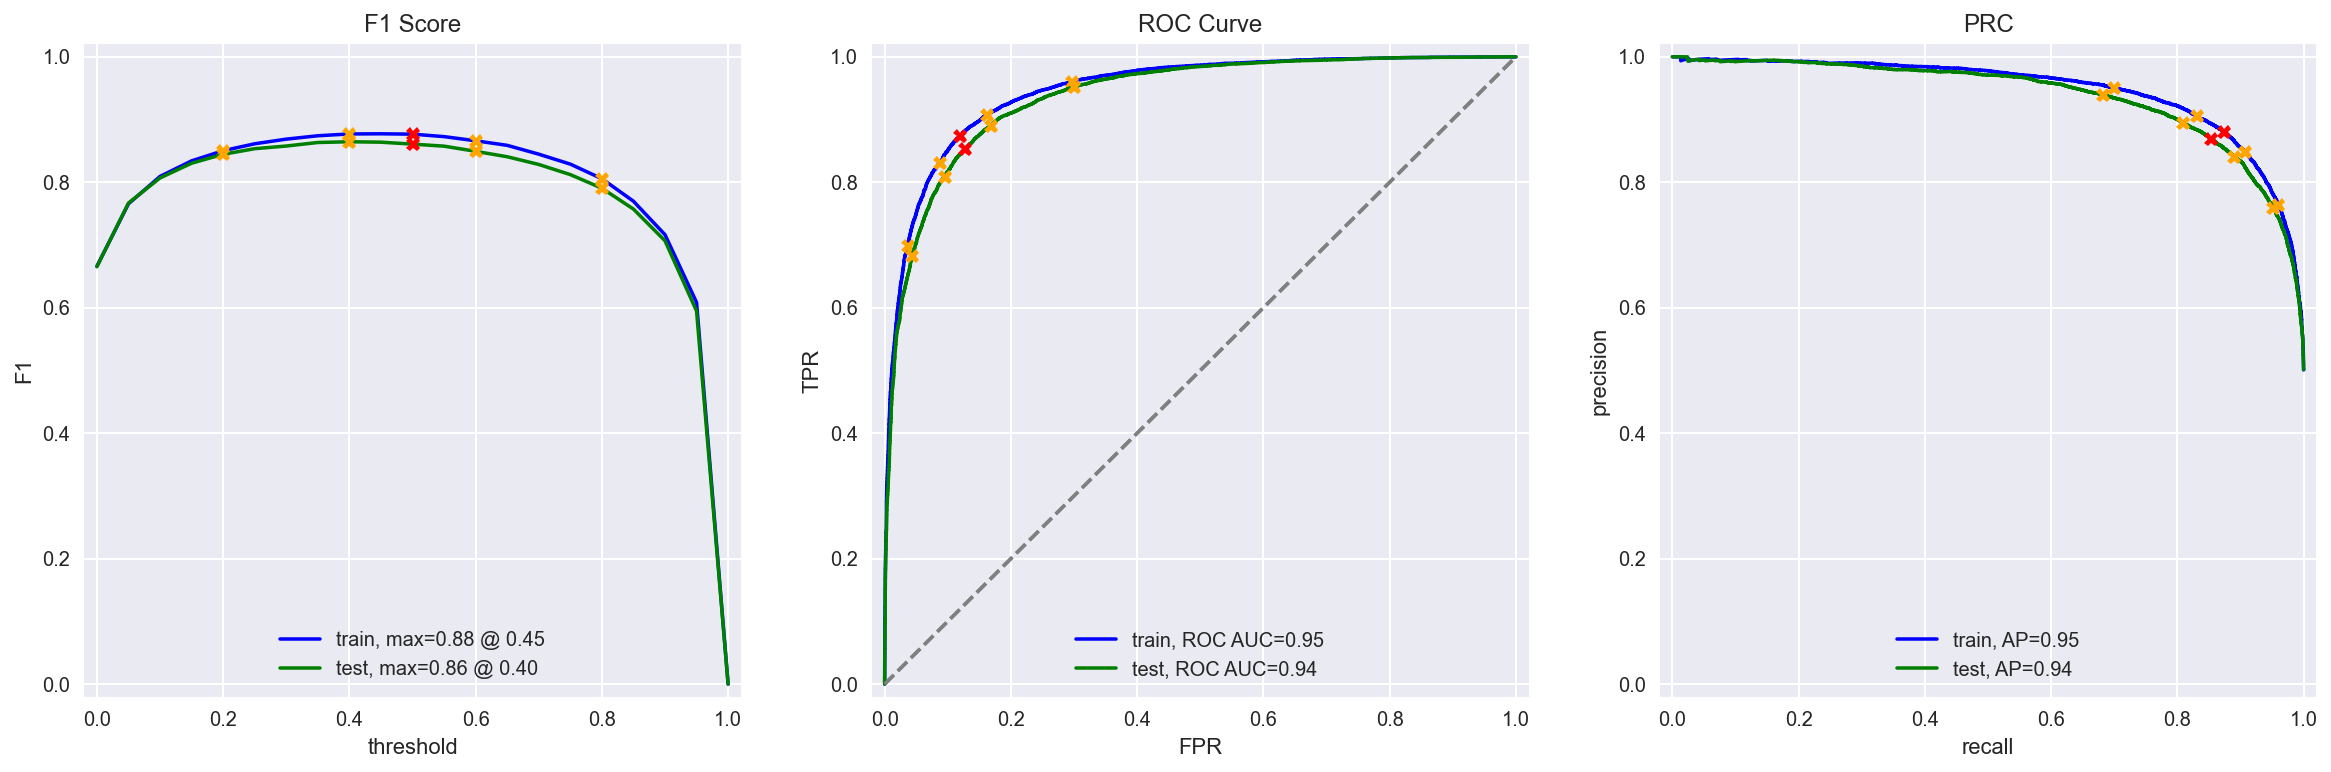

In [35]:
model_4 = LogisticRegression(max_iter=1000)
model_4.fit(train_features_4,train_target)
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


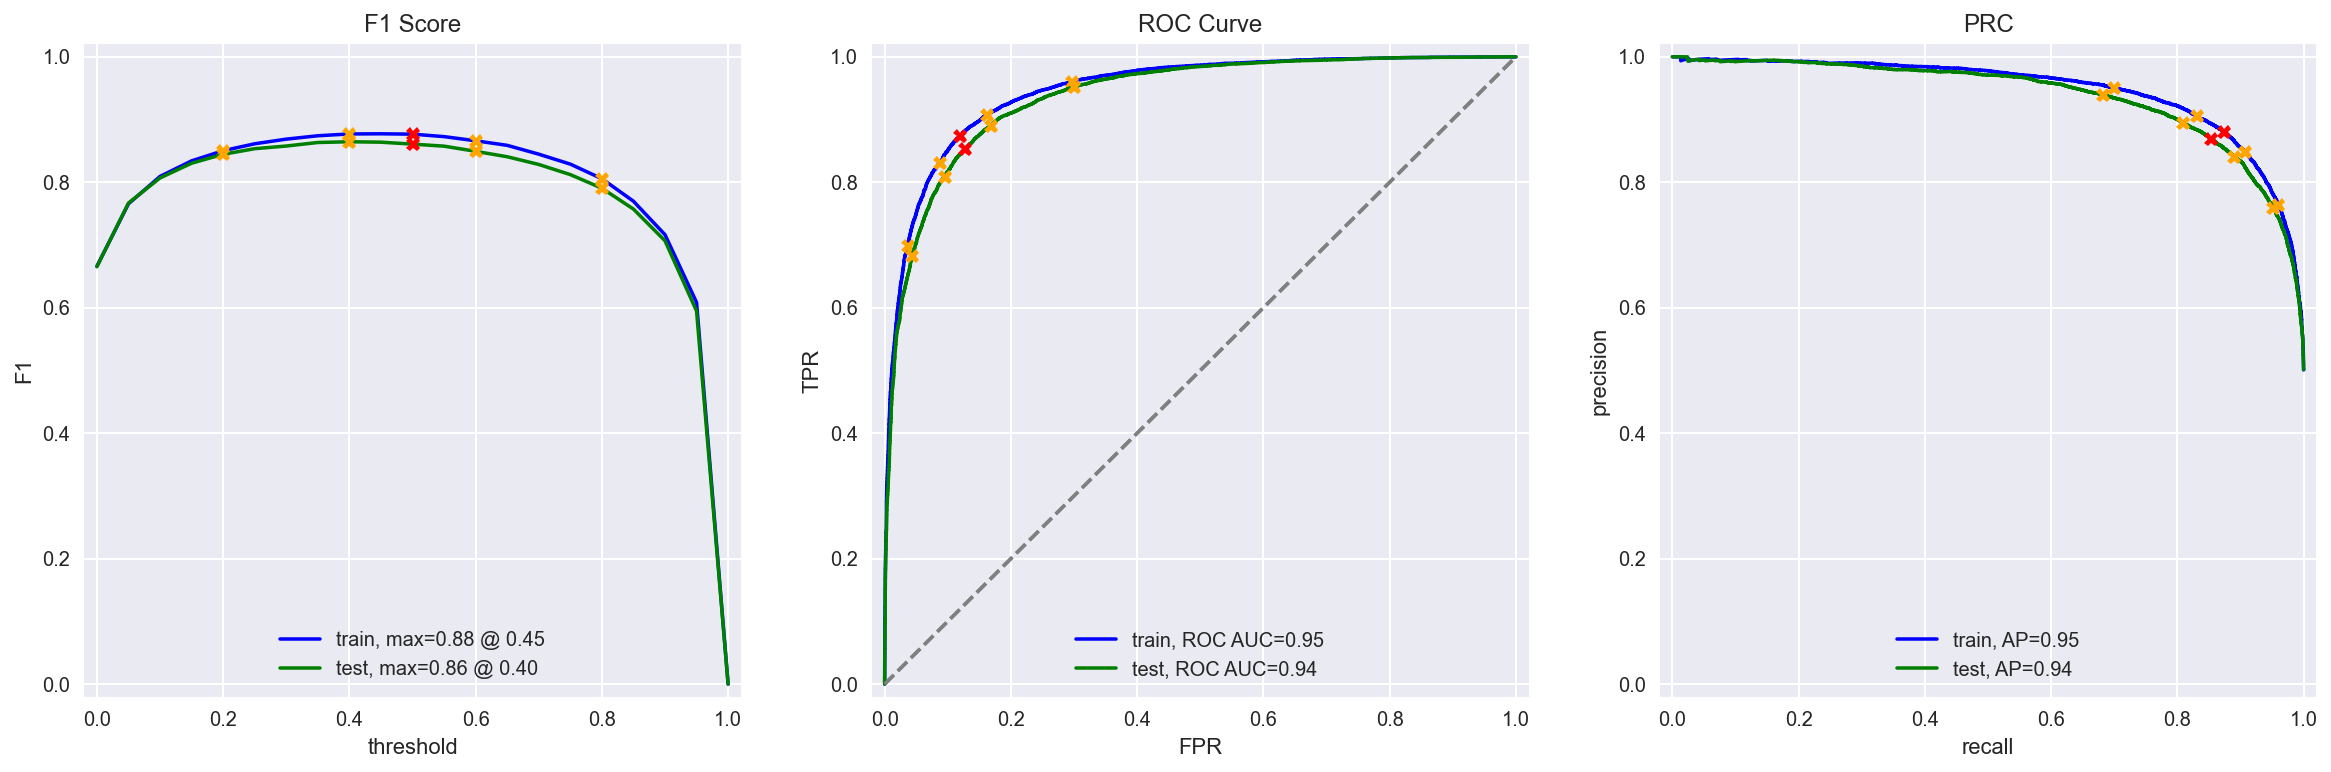

In [36]:
model_5 = LGBMClassifier()
model_5.fit(train_features_4,train_target)
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

### Conclusions

When looking at the measures of quality, all the non-dummy models performed very similarly. The only major difference was that the BERT models quality measures on the training set were slightly lower than the other models. This could be due to the review trimming done in the BERT model, yet, when it came to the testing data, they were almost exactly the same. 

Overall, I think for a simple sentiment classification task, there is no need for complex methods, such as BERT and gradient boosting.

## My Reviews

In [120]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'The movie was awful.',
    'The movie was amazing.',
    'The movie was average',
    'I hate how much I love this movie.',
    'The cinematography was incredible, but the storlyline lacked much motivation.',
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

review  \
0                               The movie was awful.   
1                             The movie was amazing.   
2                              The movie was average   
3                 I hate how much I love this movie.   
4  The cinematography was incredible, but the sto...   

                                         review_norm  
0                                the movie was awful  
1                              the movie was amazing  
2                              the movie was average  
3                  i hate how much i love this movie  
4  the cinematography was incredible but the stor...

### Model 1

In [121]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(features_fit_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  the movie was awful
0.97:  the movie was amazing
0.41:  the movie was average
0.79:  i hate how much i love this movie
0.53:  the cinematography was incredible but the storlyline lacked much motivation


### Model 2

In [122]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(features_fit_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  the movie was awful
0.97:  the movie was amazing
0.44:  the movie was average
0.74:  i hate how much i love this movie
0.22:  the cinematography was incredible but the storlyline lacked much motivation


### Model 3

In [123]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(features_fit_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.11:  the movie was awful
0.85:  the movie was amazing
0.60:  the movie was average
0.76:  i hate how much i love this movie
0.47:  the cinematography was incredible but the storlyline lacked much motivation


### Model 4

In [124]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  the movie was awful
1.00:  the movie was amazing
0.47:  the movie was average
0.78:  i hate how much i love this movie
0.29:  the cinematography was incredible but the storlyline lacked much motivation


### Model 5

In [125]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.12:  the movie was awful
0.88:  the movie was amazing
0.23:  the movie was average
0.33:  i hate how much i love this movie
0.46:  the cinematography was incredible but the storlyline lacked much motivation


### Conclusions

For these 5 phrases, I looked at the predicted probability of a positive sentiment using each of the 5 models. 

The first three phrases are supposed to be easy ones that the models should be able to predict with a very high percentage. The only models that struggled were the BERT models. The BERT model that used a logistic regression thought the phrase 'the movie was awful' had a 53% probability of being positive. Also, the BERT model that used gradient boosting, thought the phrase 'the movie was average' had a 23% probability of being positive. 

The fourth phrase used a negative word to describe an overall positive review. All the models did a good job of recognizing the overall sentiment besides the BERT model that used gradient boosting, which thought the phrase 'i hate how much i love this movie' had a 33% probability of being positive. 

Lastly, the fifth phrase included one positive aspect and one negative aspect. The spaCy and BERT logistic regression models seemed to put more weight on the negative aspect of the review, while the other three models gave even weight.

## Conclusions

Overall, I think movie reviews usually have a clear sentiment, which makes this task easier for the less complex models. In this instance, I would suggest the use of simple models to predict sentiment because they are faster and seem to before at least as well as the more complex models. 

The one interesting extension to this project would be to see how well the models can predict the overall rating. I would be interested to see if the models can pick up on the difference between a 7 out of 10 review compared to a 10 out of 10 review. 